# DeepLabCut Toolbox - DEMO for maDLC
https://github.com/AlexEMG/DeepLabCut

#### The notebook accompanies the following preprint:

*Multi-animal pose estimation and tracking with DeepLabCut.* A. Mathis et al, 2020 in prep.

This notebook illustrates how to:

- create a multi-animal project
- label the data 
- check the labels 
- create a multi-animal training dataset
- train your new deep neural network 
- evaluate network
- analyze videos
- detect tracks 
- inspect and correct tracks 
- create videos 
- create images of scoremaps, pafs, locref output layers

### You must have deeplabcut 2.2 installed (upgrade here if needed):
- this will NOT break any of your older 2.x projects!

In [ ]:
!pip install --upgrade deeplabcut

In [1]:
%cd '/home/mackenzie/DEEPLABCUT/maDLC/DLCdev'

/home/mackenzie/DEEPLABCUT/maDLC/DLCdev


## Import the toolbox:

In [2]:
!export DLClight=False
import deeplabcut
deeplabcut.__file__

'/home/mackenzie/DEEPLABCUT/maDLC/DLCdev/deeplabcut/__init__.py'

# Create a new project

It is always good idea to keep the projects seperate if you want to use different networks to analze your data. You should use one project if you are tracking similar subjects/items even if in different environments. This function creates a new project with sub-directories and a basic configuration file in the user defined directory otherwise the project is created in the current working directory.

In [ ]:
task='mwm' # Enter the name of your experiment Task
experimenter='penguins' # Enter the name of the experimenter
video=['/home/mackenzie/Desktop/penguindemo.mp4'] # Enter the paths of your videos OR FOLDER you want to grab frames from.
#CRUCIAL: you should take as diverse frames as possible from multiple videos and animals!

deeplabcut.create_new_project(task,experimenter,video,copy_videos=True, multianimal=True) 

# NOTE: The function returns the path, where your project is. 
# You could also enter this manually (e.g. if the project is already created and you want to pick up, where you stopped...)
#path_config_file = '/home/Mackenzie/myDLCProjectFolders/config.yaml' # Enter the path of the config file that was just created from the above step (check the folder)

### You also can re-load a project by just updating the path to the config.yaml below:

In [3]:
#set path to config.yaml file (printed above!)
path_config_file = '/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/config.yaml'

# CRUCIAL: go edit the config.yaml file that was created! 

You will have a config.yaml file in your project folder. 
Crucially, please set:

- **individuals**
        #set the number of animals, i.e. "indiv1, indiv2, indiv3" up to the maximum you expect to see in the
         training data. if you have video with morelater, that is fine.
- **uniquebodyparts** 
        #this are points that are not tied to an individual, i.e. something like "cornerofabox" or "LED"
- **multianimalbodyparts** 
        #this is the real bodypart per individual list (as in "normal" DLC). Please use more body parts than 
         you might have been used to previously. Now that a skeleton is used for training you want to be able
         to  connect close parts. i.e. in our mouse demo we had snout, leftear, right ear, tailbase; now you
         should also include "neck" & "spine" points i.e. perhaps spine1, spine2, spine3
- **skeleton** 
         #this is now used during training, so please connect the bodyparts in a graph. 
         CRUCIAL: You also want to over-connect; i.e. let's say you have head, body, left limb, right limb:
         - - head
           - body
         - - body 
           - leftlimb
         - - body 
           - rightlimb
         - - head 
           - leftlimb
         - - head 
           - rightlimb
         - - leftlimb
           - rightlimb
           
**Plus**, edit the number of frames to extract per video, etc. 

# Extract frames from videos 
A key point for a successful feature detector is to select diverse frames, which are typical for the behavior you study that should be labeled.

This function selects N frames either uniformly sampled from a particular video (or folder) ('uniform'). Note: this might not yield diverse frames, if the behavior is sparsely distributed (consider using kmeans), and/or select frames manually etc.

Also make sure to get select data from different (behavioral) sessions and different animals if those vary substantially (to train an invariant feature detector).

Individual images should not be too big (i.e. < 850 x 850 pixel). Although this can be taken care of later as well, it is advisable to crop the frames, to remove unnecessary parts of the frame as much as possible.

Always check the output of cropping. If you are happy with the results proceed to labeling.

In [ ]:
#AUTOMATIC:
deeplabcut.extract_frames(path_config_file) 

# Label Frames

In [ ]:
deeplabcut.label_frames(path_config_file)

# Check Labels, by bodypart:

In [ ]:
deeplabcut.check_labels(path_config_file, visualizeindividuals=False)

# Check Labels, by individual:

You can run this function "again" with the flag set to true and it saves both sets of images.

In [ ]:
deeplabcut.check_labels(path_config_file, visualizeindividuals=True)

### Here we have an extra (optional but recommended) step to crop and diversify the images before creating the training set: 

This is recommended to be able to train in batches, and especially helpful if you have lots of animals. It's worth the few minutes... plus you can then use batch training if your images were not the same size already.

In [ ]:
deeplabcut.cropimagesandlabels(path_config_file, userfeedback=False)

# Create maDLC training dataset:

Here you have several options (as always), and some new defaults! Defaults: firstly, this will use ResNet-50 with imgaug and  secondly, new ADAM optimizer with batch training (if your frames are the same size*). 

In [ ]:
deeplabcut.create_multianimaltraining_dataset(path_config_file)

#### [optional]: Here is how you can edit the pose_config.yaml before training:

In [ ]:
shuffle=1

trainposeconfigfile,testposeconfigfile,snapshotfolder=deeplabcut.return_train_network_path(path_config_file,shuffle=shuffle)
edits = {'batch_size': 16,
         'optimizer': 'adam',
         'grayscale': True,
         'rotation': 20,
         'covering': True,
         'hist_eq': True,
         'fliplr': False,
         'motion_blur': True,
         'multi_step': [[1e-4, 5000], [5*1e-5, 7500], [1e-5, 12000], [1e-6,50000]],
         'weigh_only_present_joints': False}
cfg_dlc= deeplabcut.auxiliaryfunctions.edit_config(testposeconfigfile, edits)

## Start training the multi-task DNN + Feature Detectors:
This function trains the network for a specific shuffle of the training dataset. 

Training can be stopped at any time w/CNTRL+C. Note that the weights are only stored every 'saveiters' steps. Inn reality, you will train until ~50K, so we save every 5-10K). But, you can store more frequently or display more fequently if you are DEMOing the code. Note, this is a *NEW* training regime, so if you are used to DLC 2.1 (and before), this now takes less time to train.


In [ ]:
#which shuffle do you want to train/evaluate, and analyze with?
shuffle = 3 

deeplabcut.train_network(path_config_file, shuffle=shuffle, saveiters=1000, displayiters=100, maxiters=30000)
#notice the variables "saveiters" and "dsiplayiters" that can be set in the function

## Evaluate the trained network

This function evaluates a trained model for a specific shuffle/shuffles at a particular training state (snapshot) or on all the states. The network is evaluated on the data set (images) and stores the results as .csv file in a subdirectory under **evaluation-results**.

You can change various parameters in the ```config.yaml``` file of this project. For the evaluation one can change pcutoff. This cutoff also influences how likely estimated postions need to be so that they are shown in the plots.

In [18]:
deeplabcut.evaluate_network(path_config_file,Shuffles=[shuffle], plotting=True,c_engine=False)

/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/  already exists!
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/iteration-0/mwmMar31-trainset95shuffle3  already exists!
Running  DLC_resnet50_mwmMar31shuffle3_30000  with # of trainingiterations: 30000
Model already evaluated. /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/iteration-0/mwmMar31-trainset95shuffle3/DLC_resnet50_mwmMar31shuffle3_30000-snapshot-30000.h5


## Check predictions visually before moving onwards:

- `extract_save_all_maps` allows you to plot and save the scoremaps, lofref, and pafs

- `create_video_with_all_detections` allows you to create a video of all scoremap detections, plotted a points (this is not the final product!) We recommend running this on a short video (perhaps one that you used for labeling). 

In [19]:
deeplabcut.extract_save_all_maps(path_config_file, shuffle=shuffle, Indices=[0, 5])
# you can drop "Indices" to run this on all training/testing images 
#This creates a new folder called "maps" within your evalution-results folder (shuffle specific). 

/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/  already exists!
/home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/evaluation-results/iteration-0/mwmMar31-trainset95shuffle3  already exists!
Extracting maps for  DLC_resnet50_mwmMar31shuffle3_30000  with # of trainingiterations: 30000
Initializing ResNet
Activating extracting of PAFs
INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3/train/snapshot-30000


INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3/train/snapshot-30000

0it [00:00, ?it/s]

Analyzing data...



1it [00:01,  1.13s/it]
2it [00:01,  1.52it/s]

100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


## Analyzing videos

- [1] we will analyze a new video 
- [2] utilize a new function that plots *all* detections, just to check quality (again, i.e. in addition to the network evaluation ). 

`deeplabcut.analyze_videos`: This function extracts the pose based on a trained network from videos. The user can choose the trained network - by default the most recent snapshot is used to analyse the videos. However, the user can also specify the snapshot index for the variable **snapshotindex** in the **config.yaml** file).

In maDLC the under-the-hood code is quite updated, and also now has c-code that would need to be comiled first. There is a non-c-code option though! set `c_engine=False`. It's a bit slower, but the outcome is the same. 

The results are stored in hd5 file in the same directory, where the video resides. The pose array (pose vs. frame index) can also be exported as csv file (set flag to...). 

In [20]:
# Set a video path:
#The video can be the one you trained with and new videos that look similar, i.e. same experiments, etc.
# TIP: You can add individual videos, OR a path to a folder - it will skip videos that are already analyzed once.

videofile_path = '/home/mackenzie/Desktop/penguindemo.mp4'      

In [24]:
#NOTE: c_engine = True is faster, but requires you complie c code first.  *see github for tips!
#### This is just for c-engine=True ###
import os, sys
nmspath = 'deeplabcut/pose_estimation_tensorflow/lib/nms_cython'
sys.path.append(os.path.join('/home/mackenzie/anaconda3/envs/DLC3_7/lib/python3.7/site-packages',nmspath))
#######################################

print("Start Analyzing my video(s)!")
scorername = deeplabcut.analyze_videos(path_config_file,[videofile_path], shuffle=shuffle, videotype='.mp4', c_engine=True)

Start Analyzing my video(s)!
Using snapshot-30000 for model /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3
Initializing ResNet
Activating extracting of PAFs
INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3/train/snapshot-30000


INFO:tensorflow:Restoring parameters from /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3/train/snapshot-30000


Starting to analyze %  /home/mackenzie/Desktop/penguindemo.mp4
Video already analyzed! /home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle3_30000.h5
The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


In [26]:
#You input the config path, video path, and then the scorer name:
#(note, we extracted the `scorername` now from `analyze_videos` or you can pass it here:)
# scorername = 'DLC_resnet50_mwmMar31shuffle3_30000'

# There are two pose_config.yaml inputs you might want to change (nmsradius, and minconfidence). 
# Here is a simple way to do that within the notebook:

trainposeconfigfile,testposeconfigfile,snapshotfolder=deeplabcut.return_train_network_path(path_config_file,shuffle=2)
cfg_dlc=deeplabcut.auxiliaryfunctions.read_plainconfig(testposeconfigfile)
cfg_dlc['nmsradius']=1.
cfg_dlc['minconfidence']=.01
deeplabcut.auxiliaryfunctions.write_plainconfig(testposeconfigfile,cfg_dlc)

deeplabcut.create_video_with_all_detections(path_config_file, [videofile_path], scorername)


  0%|          | 0/70 [00:00<?, ?it/s]

Creating labeled video for  penguindemo
{'nms radius': 5.0, 'minimal confidence': 0.01, 'PAFgraph': [[0, 1], [1, 3], [1, 4], [1, 2], [0, 2], [0, 3], [0, 4], [3, 2], [4, 2]], 'all_joints': [[0], [1], [2], [3], [4]], 'all_joints_names': ['head', 'neck', 'body', 'wing1', 'wing2'], 'nframes': 70, 'c_engine': True}
70



100%|██████████| 70/70 [00:00<00:00, 121.99it/s]


## Create the Multi-Animal Tracklets! 

Please note, this has quite a few parameters, and they need to be cross-validated for best performance. 

Thus, for eah project we strongly suggest you take the time to cross-validate. 

## WIP : Here is how... 

In [28]:
deeplabcut.convert_detections2tracklets?

#### This function has many parameters, and it's worith it to check out the docstring! ^

In [29]:
#assemble tracklets:
deeplabcut.convert_detections2tracklets(path_config_file, [videofile_path], shuffle=shuffle, videotype='mp4')


0it [00:00, ?it/s]

Using snapshot-30000 for model /home/mackenzie/DEEPLABCUT/DLCdev-DLC2.2/mwm-penguins-2020-03-31/dlc-models/iteration-0/mwmMar31-trainset95shuffle3
['/home/mackenzie/Desktop/penguindemo.mp4']
Processing...  /home/mackenzie/Desktop/penguindemo.mp4
Analyzing /home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle3_30000.h5



2it [00:00,  2.62it/s]
5it [00:00,  3.58it/s]
9it [00:01,  4.87it/s]
13it [00:01,  6.52it/s]
16it [00:01,  8.47it/s]
19it [00:01, 10.74it/s]
22it [00:01, 13.27it/s]
26it [00:01, 16.06it/s]
29it [00:01, 18.43it/s]
33it [00:01, 21.34it/s]
37it [00:01, 24.25it/s]
41it [00:02, 25.82it/s]
45it [00:02, 28.63it/s]
49it [00:02, 30.14it/s]
53it [00:02, 31.43it/s]
57it [00:02, 32.49it/s]
61it [00:02, 34.19it/s]
66it [00:02, 35.75it/s]
70it [00:02, 24.61it/s]

The tracklets were created. Now you can 'refine_tracklets' 
 You can create labeled videos with 'create_labeled_video'.


## Now you should manually verfiy the tracks and correct them if needed! 

In [32]:
deeplabcut.refine_tracklets?

<IPython.core.display.Javascript object>


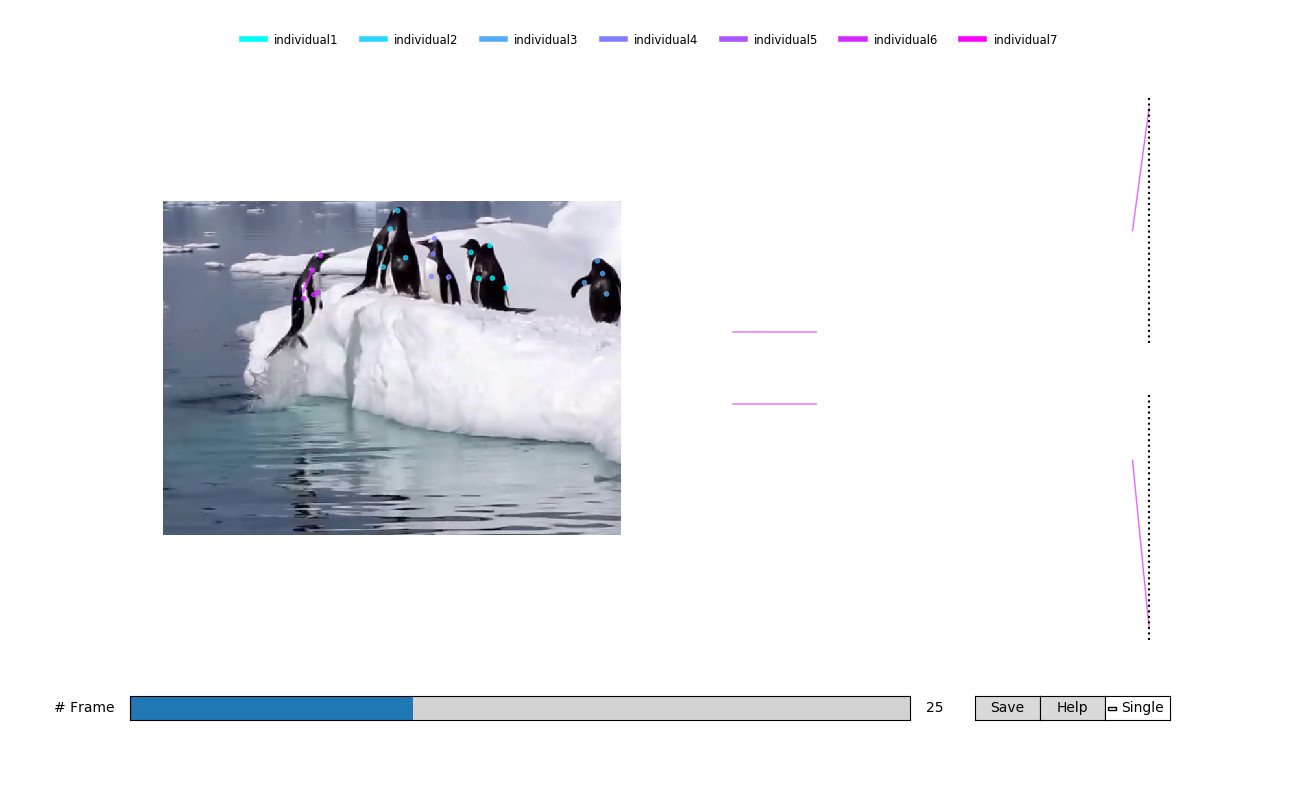

In [34]:
%matplotlib notebook
picklefile ='/home/mackenzie/Desktop/penguindemoDLC_resnet50_mwmMar31shuffle3_30000tracks.pickle'
deeplabcut.refine_tracklets(path_config_file, picklefile, videofile_path, min_swap_frac=0,min_tracklet_frac=0)

## Create labeled videos

This function is for the visualization purpose and can be used to create a video in .mp4 format with the predicted labels. This video is saved in the same directory, where the (unlabeled) video resides. 

Various parameters can be set with regard to the colormap and the dotsize (matplotlib is used in the backend). See the `config.yaml` file for how to set these.

In [ ]:
deeplabcut.create_labeled_video(path_config_file,[videofile_path], shuffle=shuffle, draw_skeleton=True, videotype='mp4', save_frames=False)

## Plot the trajectories of the analyzed videos
This function plots the trajectories of all the body parts across the entire video. Each body part is identified by a unique color. The underlying functions can easily be customized.

In [40]:
deeplabcut.plot_trajectories(path_config_file,[videofile_path],shuffle=shuffle,showfigures=True, videotype='mp4')
#These plots can are interactive and can be customized (see https://matplotlib.org/)

Starting %  /home/mackenzie/Desktop /home/mackenzie/Desktop/penguindemo.mp4
No data were found in /home/mackenzie/Desktop.
The video was not analyzed with this scorer: DLC_resnet50_mwmMar31shuffle3_30000
Plots could not be created! Videos were not evaluated with the current scorer DLC_resnet50_mwmMar31shuffle3_30000.


## Extract outlier frames, where the predictions are off.

This is optional step allows to add more training data when the evaluation results are poor. In such a case, the user can use the following function to extract frames where the labels are incorrectly predicted. Make sure to provide the correct value of the "iterations" as it will be used to create the unique directory where the extracted frames will be saved.

In [ ]:
# Note, if you have questions on parameters, remember "?" gives you answers:
deeplabcut.extract_outlier_frames?

In [ ]:
deeplabcut.extract_outlier_frames(path_config_file,videofile_path,outlieralgorithm='uncertain',p_bound=.2)

The user can run this iteratively, and (even) extract additional frames from the same video.

## Manually correct labels

This step allows the user to correct the labels in the extracted frames. Navigate to the folder with the videos and use the GUI as described in the protocol to update the labels.

In [ ]:
#GUI pops up! 
#sometimes you need to restart the kernel for the GUI to launch.
%gui wx
deeplabcut.refine_labels(path_config_file)

In [ ]:
# Now merge datasets (once you refined all frames)
deeplabcut.merge_datasets(path_config_file)

## Create a new iteration of training dataset, check it and train...

Following the refine labels, append these frames to the original dataset to create a new iteration of training dataset.

In [ ]:
#Perhaps plot the labels to see how how all the frames are annotated (including the refined ones)
deeplabcut.check_labels(path_config_file)
# if they are off, you can load them in the labeling_gui to adjust!

In [ ]:
deeplabcut.create_training_dataset(path_config_file)

Now one can train the network again... (with the expanded data set)

In [ ]:
deeplabcut.train_network(path_config_file)